In [1]:
#Library Imports
import kwant
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import numpy as np
import tinyarray as ta
import pylab
%matplotlib notebook

In [2]:
def hop(a, s_eye, s_y):
    '''
    Defines hopping energy constant.
    '''
    hopping_potential = -1/(2*a**2)*(s_eye) + 1j*(s_y)/(2*a)
    
    return hopping_potential

In [3]:
def onSite(a, mu, s_eye, s_x):
    '''
    Defines on-site energy constant.
    '''
    onsite_potential = 1/(a**2)*(s_eye) - mu*(s_eye) + (s_x) # + (s_x) accounts for Zeeman term.
    
    
    return onsite_potential

In [4]:
def pair(delta, s_eye):
    '''
    Defines energy constant for Cooper Pair formation.
    '''
    theta = 1
    pairing_potential_partial = delta * theta * s_eye 
    
    return pairing_potential_partial

In [5]:
def energy(a, L, W, s_eye, s_x, s_y, s_z, mu, delta, Vx):  #energy(a, L, W, mu, delta, s_eye, s_x, s_y, s_z, Vx):
    '''
    Computes lowest energy eigenvalues of system.
    '''
    #Hamiltonian
    sys = kwant.Builder()

    #Lattice Definitions
    lat_e = kwant.lattice.square(a, name='e')
    lat_h = kwant.lattice.square(a, name='h')

    #Hamiltonian
    j = 0
    
    for i in range(L):
            sys[lat_e(i,j)] = onSite(a, mu, s_eye, s_x * Vx) #On-site (electrons)
            sys[lat_h(i,j)] = -onSite(a, mu, s_eye, -s_x * Vx) #On-site (holes)

            if (i > 0):
                sys[lat_e(i-1,j), lat_e(i,j)] = hop(a, s_eye, s_y)
                sys[lat_h(i-1,j), lat_h(i,j)] = -hop(a, s_eye, s_y)
                sys[lat_e(i,j), lat_h(i,j)] = pair(delta, s_eye)     

    ham_mat = sys.finalized().hamiltonian_submatrix(sparse=True)
    ev = sla.eigsh(ham_mat, k=8, which='SM', return_eigenvectors=False, maxiter = 1000000)
    
    return ev


In [6]:
def plot_energies(a, L, W, mu, Vx, s_eye, s_x, s_y, s_z):
    '''
    Confirms system can support zero energy modes.
    Plots energy versus a variable pairing potential (delta).
    '''
    energies = []
    deltarange = np.linspace(0, 0.3, 11)
    
    for delta in deltarange:
        energies.append(np.sort(energy(a, L, W, s_eye, s_x, s_y, s_z, mu, delta, Vx)))

    plt.figure()
    plt.title("Energy vs Pairing Potential")
    plt.plot(deltarange, energies)
    plt.xlabel("Pairing Potential")
    plt.ylabel("Energy")
    plt.show()
    print(energies)

In [7]:
def phase_diagram_mu(a, L, W, s_eye, s_x, s_y, s_z, mu_range, delta, Vx):
    '''
    Plots diagram of triviality vs. a range of mu. Delta and Vx remain constant.
    '''
    x = []
    y = []
    C_arr = []
    
    for mu in mu_range:
        min_ev = np.amin(np.absolute(energy(a, L, W, s_eye, s_x, s_y, s_z, mu, delta, Vx)))
        print(min_ev)
        x.append(mu)
        
        if min_ev < (10**(-11)): #topological
            y.append(2)
            
        else:
            y.append(1)
            
        C_0 = mu**2 + delta**2 - Vx**2
        C_arr.append(C_0)
            
    print("mu_range = ", mu_range)
    print("C_arr = ", C_arr)
    print(y)  

In [8]:
def phase_diagram_delta(a, L, W, s_eye, s_x, s_y, s_z, mu, delta_range, Vx):
    '''
    Plots diagram of triviality vs. a range of delta. Mu and Vx remain constant.
    '''
    x = []
    y = []
    C_arr = []
    
    for delta in delta_range:
        min_ev = np.amin(np.absolute(energy(a, L, W, s_eye, s_x, s_y, s_z, mu, delta, Vx)))
        print(min_ev)
        x.append(delta)
                
        if min_ev < (10**(-11)): #topological
            y.append(2)
            
        else: #note to self: without the 'else', y.append(1) will ALWAYS execute
            y.append(1)
    
        C_0 = mu**2 + delta**2 - Vx**2
        C_arr.append(C_0)
            
    print("delta_range = ", delta_range)
    print("C_arr = ", C_arr)
    print(y)

In [9]:
def phase_diagram_Vx(a, L, W, s_eye, s_x, s_y, s_z, mu, delta, Vx_range):
    '''
    Plots diagram of triviality vs. a range of Vx. Mu and Delta remain constant
    '''
    x = []
    y = []
    C_arr = []
    
    for Vx in Vx_range:
        min_ev = np.amin(np.absolute(energy(a, L, W, s_eye, s_x, s_y, s_z, mu, delta, Vx)))
        print(min_ev)
        x.append(Vx)
        
        if min_ev < (10**(-11)): #topological
            y.append(2)
        
        else:
            y.append(1)
            
        C_0 = mu**2 + delta**2 - Vx**2
        C_arr.append(C_0)
            
    print("Vx_range = ", Vx_range)
    print("C_arr = ", C_arr)
    print(y)

In [10]:
'''
Expectation: For delta > 0.2, there should be a trivial regime. 
'''
#System Parameters
a = 1.
W = 1
L = 400 #250 
mu = 0.
delta_range = np.linspace(0, 0.3, 10)
Vx = 0.2

#Pauli Matrices
s_eye = ta.array([
        [1, 0], 
        [0, 1]
        ]) 
    
s_x = ta.array([ 
        [0, 1],
        [1, 0]
        ])
    
s_y = ta.array([ 
        [0,-1j],
        [1j, 0] 
        ])

s_z = ta.array([ 
        [1, 0],
        [0,-1] 
        ])

#%time phase_diagram_delta(a, L, W, s_eye, s_x, s_y, s_z, mu, delta_range, Vx) 

In [11]:
'''
Expectation: For mu > sqrt(0.03) = 0.1732, there should be a trivial regime.
'''
#is it eV/mol for chem potential?

#System Parameters
a = 1.
W = 1
L = 10 #250 
mu_range = np.linspace(0, 0.3, 10)
delta = 0.1
Vx = 0.2

#Pauli Matrices
s_eye = ta.array([
        [1, 0], 
        [0, 1]
        ]) 
    
s_x = ta.array([ 
        [0, 1],
        [1, 0]
        ])
    
s_y = ta.array([ 
        [0,-1j],
        [1j, 0] 
        ])

s_z = ta.array([ 
        [1, 0],
        [0,-1] 
        ])

#%time phase_diagram_mu(a, L, W, s_eye, s_x, s_y, s_z, mu_range, delta, Vx) 

In [12]:
'''
Expectation: For Vx < 0.1, there should be a trivial regime.
'''
#is it eV/mol for chem potential?

#System Parameters
a = 1.
W = 1
L = 400 
mu = 0
delta = 0.1
Vx_range = np.linspace(0, 0.3, 10)

#Pauli Matrices
s_eye = ta.array([
        [1, 0], 
        [0, 1]
        ]) 
    
s_x = ta.array([ 
        [0, 1],
        [1, 0]
        ])
    
s_y = ta.array([ 
        [0,-1j],
        [1j, 0] 
        ])

s_z = ta.array([ 
        [1, 0],
        [0,-1] 
        ])

#%time phase_diagram_Vx(a, L, W, s_eye, s_x, s_y, s_z, mu, delta, Vx_range) 

In [13]:
def phase_diagram_A(fig_num, a, L, W, s_eye, s_x, s_y, s_z, mu_range, delta, Vx):
    '''
    Plots a phase diagram of triviality vs. C_0. Delta and Vx remain constant while mu changes.
    '''
    C_arr = []
    triviality = [] #Trivial (1); Non-trivial (2)
  
    for mu in mu_range:
        min_ev = np.amin(np.absolute(energy(a, L, W, s_eye, s_x, s_y, s_z, mu, delta, Vx)))
        print(min_ev)
        
        C_0 = mu**2 + delta**2 - Vx**2
        C_arr.append(C_0)
        
        if min_ev < (10**(-11)): #C_0 > 0:
            triviality.append(2)
        
        elif min_ev == (10**(-11)): #C_0 == 0:
            triviality.append(1.5)
        
        else:
            triviality.append(1)
    
    plt.figure(fig_num)
    plt.scatter(C_arr, triviality) #Note that plt.plot is slightly slower than plt.scatter.
    plt.show()
    
    plt.ylabel("Non-Trivial = 2, Boundary = 1.5, Trivial = 1")
    plt.xlabel("C_0")
    plt.title("1D Phase Diagram: Triviality vs. Delta", y = 1.0)

In [14]:
def phase_diagram_B(fig_num, a, L, W, s_eye, s_x, s_y, s_z, mu, delta_range, Vx):
    '''
    Plots a phase diagram of triviality vs. C_0. Mu and Vx remain constant while delta changes.
    '''
    C_arr = []
    triviality = [] #Trivial (1); Non-trivial (2)
  
    for delta in delta_range:
        min_ev = np.amin(np.absolute(energy(a, L, W, s_eye, s_x, s_y, s_z, mu, delta, Vx)))
        print(min_ev)
        
        C_0 = mu**2 + delta**2 - Vx**2
        C_arr.append(C_0)
        
        if min_ev < (10**(-11)): #C_0 > 0:
            triviality.append(2)
        
        elif min_ev == (10**(-11)): #C_0 == 0:
            triviality.append(1.5)
        
        else:
            triviality.append(1)
            
    plt.figure(fig_num)
    plt.scatter(C_arr, triviality) #Note that plt.plot is slightly slower than plt.scatter.
    plt.draw()
    
    plt.ylabel("Non-Trivial = 2, Boundary = 1.5, Trivial = 1")
    plt.xlabel("C_0")
    plt.title("1D Phase Diagram: Triviality vs. Delta", y = 1.0)

In [15]:
def phase_diagram_C(fig_num, a, L, W, s_eye, s_x, s_y, s_z, mu, delta, Vx_range):
    '''
    Plots a phase diagram of triviality vs. C_0. Mu and Vx remain constant while delta changes.
    '''
    C_arr = []
    triviality = [] #Trivial (1); Non-trivial (2)
  
    for Vx in Vx_range:
        min_ev = np.amin(np.absolute(energy(a, L, W, s_eye, s_x, s_y, s_z, mu, delta, Vx)))
        print(min_ev)
        
        C_0 = mu**2 + delta**2 - Vx**2
        C_arr.append(C_0)
        
        if min_ev < (10**(-11)): #C_0 > 0:
            triviality.append(2)
        
        elif min_ev == (10**(-11)): #C_0 == 0:
            triviality.append(1.5)
        
        else:
            triviality.append(1)
    
    plt.figure(fig_num)
    plt.scatter(C_arr, triviality) #Note that plt.plot is slightly slower than plt.scatter.
    plt.draw()
    
    plt.ylabel("Non-Trivial = 2, Boundary = 1.5, Trivial = 1")
    plt.xlabel("C_0")
    plt.title("1D Phase Diagram: Triviality vs. Delta", y = 1.0)

0.00540316534983
0.000546404145683
1.63898044052e-05
3.68520673826e-07
7.01543433838e-09
5.86220308337e-10
4.72954454423e-08
2.8981755392e-06
0.00014504362367
0.00367785679756
0.0184595875469
0.0380810265324
0.0587618455222
0.0797839969282
0.100950622732


<IPython.core.display.Javascript object>


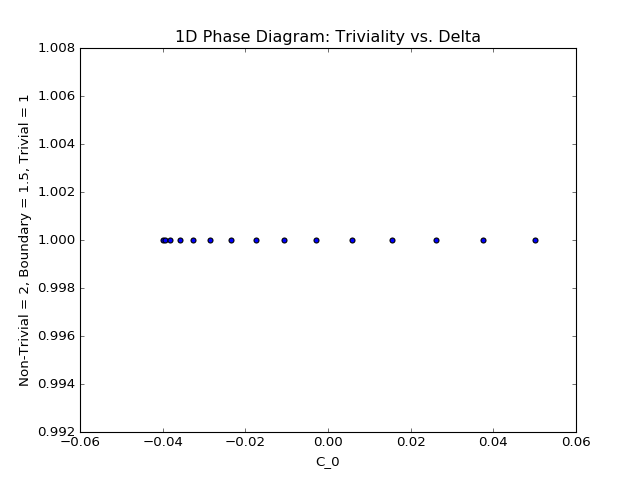

Wall time: 25.3 s


In [16]:
'''
Trial 1 (L=200)
'''
fig_num = 1

#System Parameters
a = 1.
W = 1
L = 200
mu = 0.
delta_range = np.linspace(0, 0.3, 15)
Vx = 0.2

#Pauli Matrices
s_eye = ta.array([
        [1, 0], 
        [0, 1]
        ]) 
    
s_x = ta.array([ 
        [0, 1],
        [1, 0]
        ])
    
s_y = ta.array([ 
        [0,-1j],
        [1j, 0] 
        ])

s_z = ta.array([ 
        [1, 0],
        [0,-1] 
        ])

%time phase_diagram_B(fig_num, a, L, W, s_eye, s_x, s_y, s_z, mu, delta_range, Vx)

0.00318287002086
9.04914079e-06
3.71722012535e-09
8.68965680687e-13
5.79177016149e-18
7.98763052294e-17
3.00187706272e-14
1.32228392375e-10
4.78805260191e-07
0.000777717901287
0.0157387725708
0.0364256569565
0.0576088973709
0.0789153659576
0.100269689335


<IPython.core.display.Javascript object>


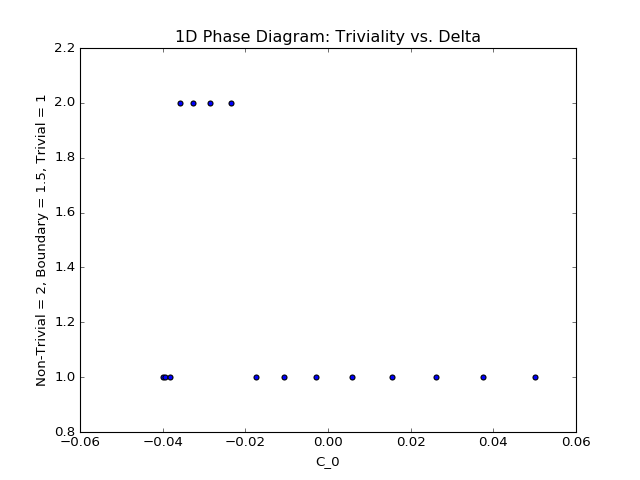

Wall time: 1min 59s


In [17]:
'''
Trial 2 (L=400)
'''
fig_num = 2 

#System Parameters
a = 1.
W = 1
L = 400
mu = 0.
delta_range = np.linspace(0, 0.3, 15)
Vx = 0.2

#Pauli Matrices
s_eye = ta.array([
        [1, 0], 
        [0, 1]
        ]) 
    
s_x = ta.array([ 
        [0, 1],
        [1, 0]
        ])
    
s_y = ta.array([ 
        [0,-1j],
        [1j, 0] 
        ])

s_z = ta.array([ 
        [1, 0],
        [0,-1] 
        ])

%time phase_diagram_B(fig_num, a, L, W, s_eye, s_x, s_y, s_z, mu, delta_range, Vx)

0.000814434368578
5.67988673507e-08
2.35962233735e-14
4.92346647127e-17
1.32479318758e-16
6.14348974958e-17
9.30759946511e-17
6.01272731314e-15
1.58070143895e-09
0.000183951143427
0.0150189131977
0.0360513686576
0.0573602695158
0.0787310812448
0.100125243235


<IPython.core.display.Javascript object>


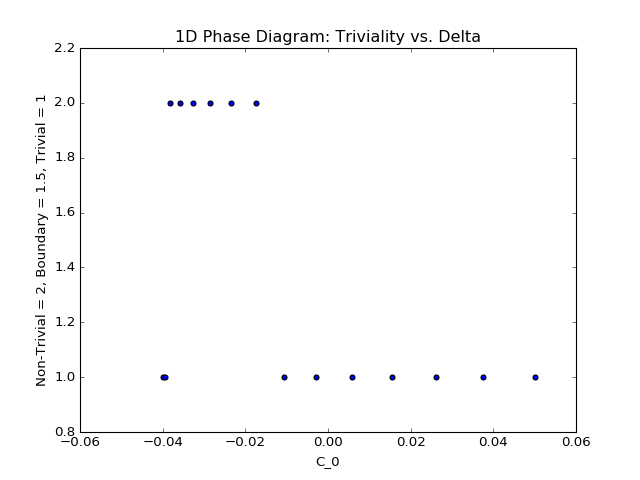

Wall time: 5min 50s


In [18]:
'''
Trial 3 (L=600)
'''
fig_num = 3

#System Parameters
a = 1.
W = 1
L = 600
mu = 0.
delta_range = np.linspace(0, 0.3, 15)
Vx = 0.2

#Pauli Matrices
s_eye = ta.array([
        [1, 0], 
        [0, 1]
        ]) 
    
s_x = ta.array([ 
        [0, 1],
        [1, 0]
        ])
    
s_y = ta.array([ 
        [0,-1j],
        [1j, 0] 
        ])

s_z = ta.array([ 
        [1, 0],
        [0,-1] 
        ])

%time phase_diagram_B(fig_num, a, L, W, s_eye, s_x, s_y, s_z, mu, delta_range, Vx)

In [19]:
'''
Plot Energies
'''
fig_num = 3

#System Parameters
a = 1.
W = 1
L = 300
mu = 0.
Vx = 0.2

#Pauli Matrices
s_eye = ta.array([
        [1, 0], 
        [0, 1]
        ]) 
    
s_x = ta.array([ 
        [0, 1],
        [1, 0]
        ])
    
s_y = ta.array([ 
        [0,-1j],
        [1j, 0] 
        ])

s_z = ta.array([ 
        [1, 0],
        [0,-1] 
        ])

#%time plot_energies(a, L, W, mu, Vx, s_eye, s_x, s_y, s_z)

In [20]:
#Seems like "run all" is faster than "run selected"